In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from keras.models import Sequential
from keras.layers import GRU, Dense
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt

In [3]:
data_path = 'imputed 2007-2023 (1).csv'
df = pd.read_csv(data_path, parse_dates=['Date'])

In [4]:
print(df.head())

        Date  open   high   low  close        Volume
0 2007-11-06  98.0  102.0  89.0   98.0  1.274430e+09
1 2007-11-07  98.0  103.0  97.0  101.0  3.493300e+08
2 2007-11-08  99.0  100.0  96.0   99.0  6.627000e+07
3 2007-11-09  95.0   97.0  95.0   95.0  4.007500e+07
4 2007-11-12  90.0   95.0  89.0   90.0  1.132850e+08


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['close'] = scaler.fit_transform(np.array(df['close']).reshape(-1, 1))

In [6]:
print(df.head())

        Date  open   high   low     close        Volume
0 2007-11-06  98.0  102.0  89.0  0.019157  1.274430e+09
1 2007-11-07  98.0  103.0  97.0  0.020799  3.493300e+08
2 2007-11-08  99.0  100.0  96.0  0.019704  6.627000e+07
3 2007-11-09  95.0   97.0  95.0  0.017515  4.007500e+07
4 2007-11-12  90.0   95.0  89.0  0.014778  1.132850e+08


In [7]:
training_size = int(len(df) * 0.9)
test_size = len(df) - training_size
train_data, test_data = df['close'][0:training_size], df['close'][training_size:len(df)]

In [8]:
def create_dataset(data, window_size=1):
    X, Y = [], []
    for i in range(len(data)-window_size-1):
        a = data[i:(i+window_size), 0]
        X.append(a)
        Y.append(data[i + window_size, 0])
    return np.array(X), np.array(Y)

In [9]:
window_size= 30  # Jumlah lag untuk input GRU
X_train, y_train = create_dataset(train_data.values.reshape(-1,1), window_size)
X_test, y_test = create_dataset(test_data.values.reshape(-1,1), window_size)

In [10]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [11]:
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(window_size, 1)))
model.add(GRU(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              metrics=["mean_squared_error"],
              loss=tf.keras.losses.Huber())

In [13]:
model.fit(X_train, y_train, epochs=1000,
          validation_data=(X_test, y_test),
          verbose=1)

Epoch 1/1000
112/112 [==============================] - 8s 38ms/step - loss: 0.0220 - mean_squared_error: 0.0440 - val_loss: 0.0017 - val_mean_squared_error: 0.0034
Epoch 2/1000
112/112 [==============================] - 4s 36ms/step - loss: 0.0015 - mean_squared_error: 0.0029 - val_loss: 3.0517e-04 - val_mean_squared_error: 6.1034e-04
Epoch 3/1000
112/112 [==============================] - 4s 36ms/step - loss: 3.0401e-04 - mean_squared_error: 6.0803e-04 - val_loss: 1.2686e-04 - val_mean_squared_error: 2.5372e-04
Epoch 4/1000
112/112 [==============================] - 3s 29ms/step - loss: 2.0242e-04 - mean_squared_error: 4.0485e-04 - val_loss: 1.2481e-04 - val_mean_squared_error: 2.4963e-04
Epoch 5/1000
112/112 [==============================] - 3s 29ms/step - loss: 1.9664e-04 - mean_squared_error: 3.9329e-04 - val_loss: 1.2374e-04 - val_mean_squared_error: 2.4747e-04
Epoch 6/1000
112/112 [==============================] - 4s 38ms/step - loss: 1.9304e-04 - mean_squared_error: 3.8609e-0

In [14]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

12/12 [==============================] - 0s 9ms/step


In [15]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


In [16]:
train_mape = mean_absolute_percentage_error(y_train, train_predict)
test_mape = mean_absolute_percentage_error(y_test, test_predict)

train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [17]:
print(f'Train MAPE: {train_mape}, Train RMSE: {train_rmse}')
print(f'Test MAPE: {test_mape}, Test RMSE: {test_rmse}')

Train MAPE: 0.023792832663977994, Train RMSE: 23.782283214402575
Test MAPE: 0.022337943436085316, Test RMSE: 18.37070745864154


In [18]:
train_plot = np.empty_like(df['close'])
train_plot[:] = np.nan
train_plot[window_size:len(train_predict)+window_size] = train_predict[:,0]

test_plot = np.empty_like(df['close'])
test_plot[:] = np.nan
test_plot[len(train_predict)+(window_size*2)+1:len(df)-1] = test_predict[:,0]

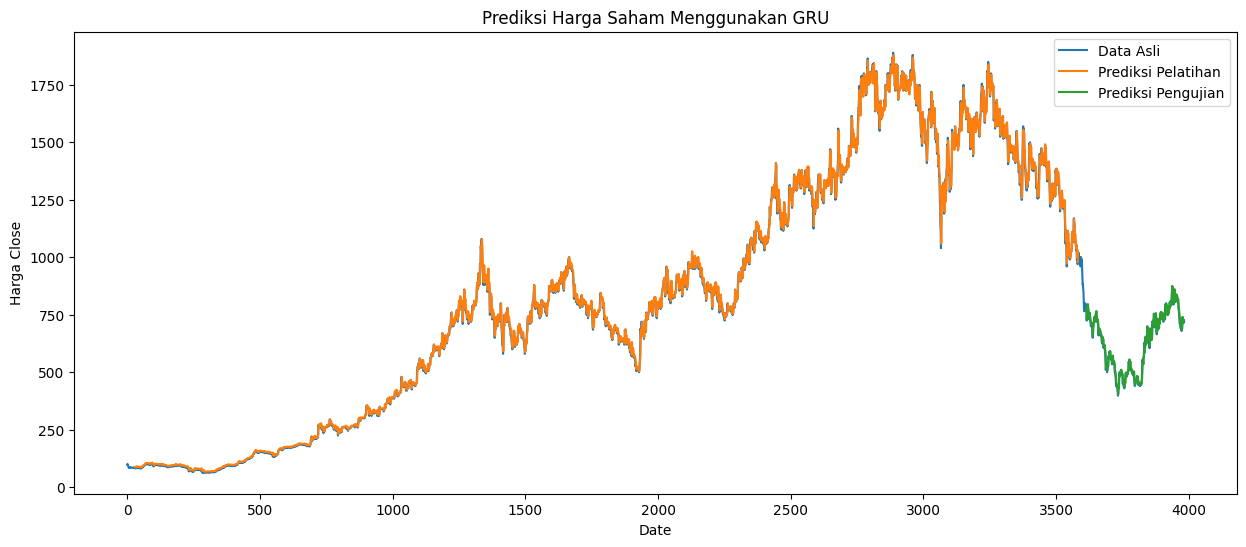

In [19]:
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(df['close'].values.reshape(-1, 1)), label='Data Asli')
plt.plot(train_plot, label='Prediksi Pelatihan')
plt.plot(test_plot, label='Prediksi Pengujian')
plt.xlabel('Date')
plt.ylabel('Harga Close')
plt.title('Prediksi Harga Saham Menggunakan GRU')
plt.legend()
plt.show()

In [20]:
# Gabungkan data asli dan prediksi ke dalam DataFrame
result_df = df[['Date']].copy()
result_df['Actual'] = scaler.inverse_transform(df['close'].values.reshape(-1, 1))
result_df['Train_Predict'] = np.nan
result_df['Test_Predict'] = np.nan

In [21]:
result_df.iloc[window_size:len(train_predict) + window_size, result_df.columns.get_loc('Train_Predict')] = train_predict[:, 0]
result_df.iloc[len(train_predict) + (window_size * 2) + 1:len(df) - 1, result_df.columns.get_loc('Test_Predict')] = test_predict[:, 0]


In [22]:
def predict_future_prices(model, data, window_size, future_days):
    future_predictions = []
    last_window = data[-window_size:]

    for day in range(future_days):
        pred = model.predict(last_window.reshape(1, window_size, 1))
        future_predictions.append(pred[0, 0])
        last_window = np.append(last_window[1:], pred[0, 0])

    return np.array(future_predictions).reshape(-1, 1)

In [23]:
future_days = 90
future_predictions = predict_future_prices(model, test_data.values, window_size, future_days)


1/1 [==============================] - 0s 23ms/step


In [24]:

# Invers transformasi hasil prediksi ke skala aslinya
future_predictions = scaler.inverse_transform(future_predictions)

In [25]:
future_dates = pd.date_range(start=df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=future_days)
future_df = pd.DataFrame({'Date': future_dates, 'Future_Predict': future_predictions.flatten()})


In [26]:
# Gabungkan data asli dan prediksi masa depan ke dalam DataFrame
result_df = pd.concat([result_df, future_df], ignore_index=True)


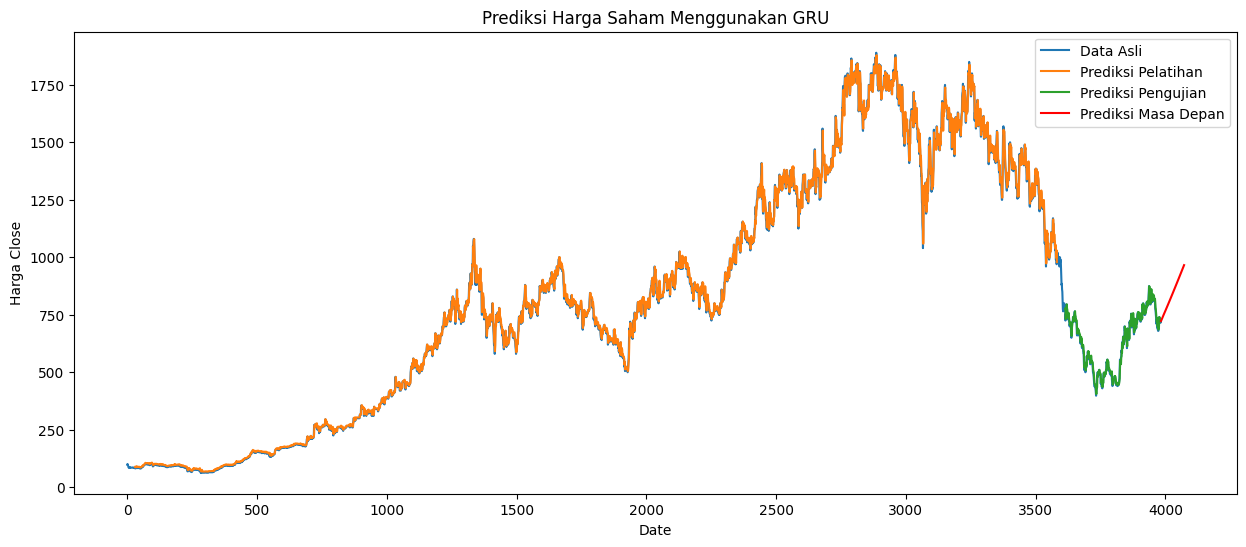

In [27]:
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(df['close'].values.reshape(-1, 1)), label='Data Asli')
plt.plot(train_plot, label='Prediksi Pelatihan')
plt.plot(test_plot, label='Prediksi Pengujian')
plt.plot(np.arange(len(df), len(df) + future_days), future_predictions, label='Prediksi Masa Depan', color='red')
plt.xlabel('Date')
plt.ylabel('Harga Close')
plt.title('Prediksi Harga Saham Menggunakan GRU')
plt.legend()
plt.show()

In [28]:
result_df.to_csv('gru_prediction_relu128_4.csv', index=False)
print('Hasil prediksi telah disimpan ke dalam file "gru_prediction(tanh128).csv".')

Hasil prediksi telah disimpan ke dalam file "gru_prediction(tanh128).csv".


In [29]:
# Tambahkan import untuk menyimpan ke Excel
from openpyxl import Workbook

In [30]:
result_df.to_excel('gru_prediction_relu128_8.xlsx', index=False)
print('Hasil prediksi telah disimpan ke dalam file "gru_prediction.xlsx".')

Hasil prediksi telah disimpan ke dalam file "gru_prediction.xlsx".
